In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import pyaudio
import wave
import sys

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

ImportError: cannot import name 'LayerNormalization' from 'tensorflow.python.keras.layers.normalization' (C:\Users\aryan\anaconda3\lib\site-packages\tensorflow\python\keras\layers\normalization\__init__.py)

In [4]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

In [3]:
tf.__version__

'2.6.0'

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [6]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\no\\b06c19b0_nohash_0.wav', shape=(), dtype=string)


In [7]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [130]:
def decode_audio(audio_binary):
  raw_audio = tf.io.read_file(audio_binary)
  audio, _ = tf.audio.decode_wav(raw_audio)
  return tf.squeeze(audio, axis=-1)

In [9]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]

In [10]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

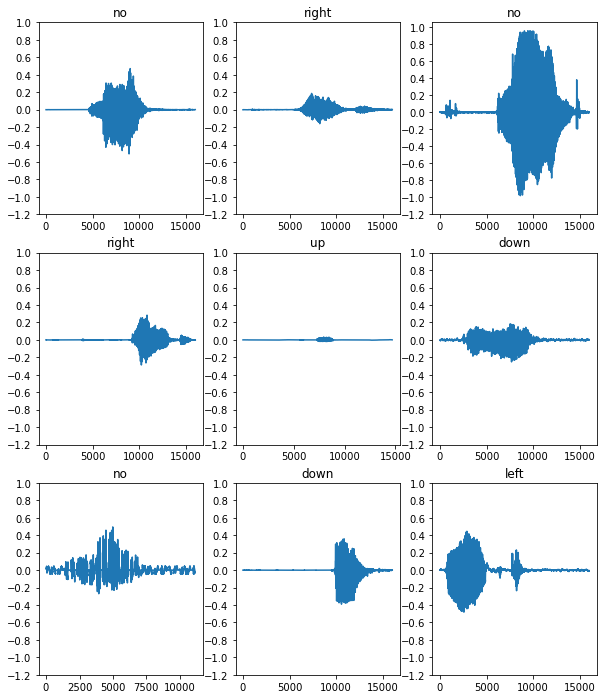

In [12]:
# plotting

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [124]:
def get_spectrogram(waveform):
  print("waveform: ", waveform.shape, waveform.dtype, type(waveform))
  wabs = tf.abs(waveform)
  wmax = tf.argmax(wabs)
  wmax = tf.cast(wmax, tf.float32)
  wmin = tf.argmin(wabs)
  wmin = tf.cast(wmin, tf.float32)
  waveform = waveform / wmax
  # Padding for files with less than 16000 samples
  # zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
  peaktopeak = tf.experimental.numpy.ptp(waveform)
  waveform = 2.0*(waveform - wmin)/peaktopeak - 1
  
  max_index = tf.argmax(waveform)
  start = tf.argmax(0, max_index - 8000)
  end = tf.argmax(0, start + 8000)
  waveform = waveform[start:end]
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  # equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)
  print("waveform: ", waveform.shape, waveform.dtype, type(waveform))

  return spectrogram

In [14]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


<ipython-input-15-adf6da8c0927>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


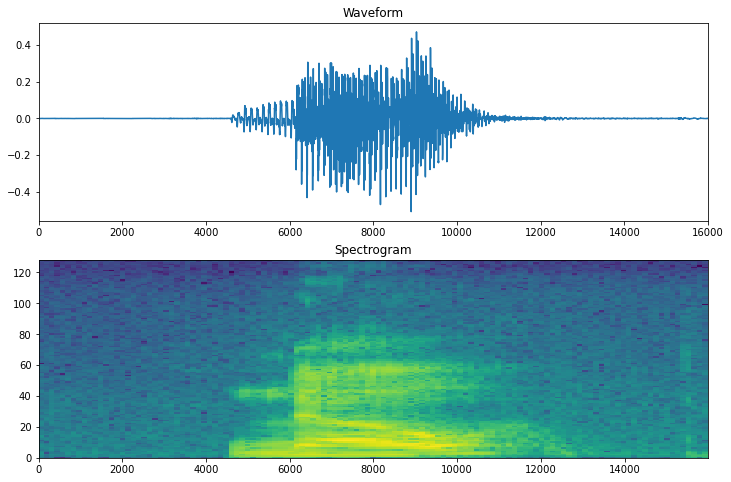

In [15]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns). An epsilon is added to avoid log of zero.
  log_spec = np.log(spectrogram.T+np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [151]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [17]:
spectrogram_dataset = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

<ipython-input-15-adf6da8c0927>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


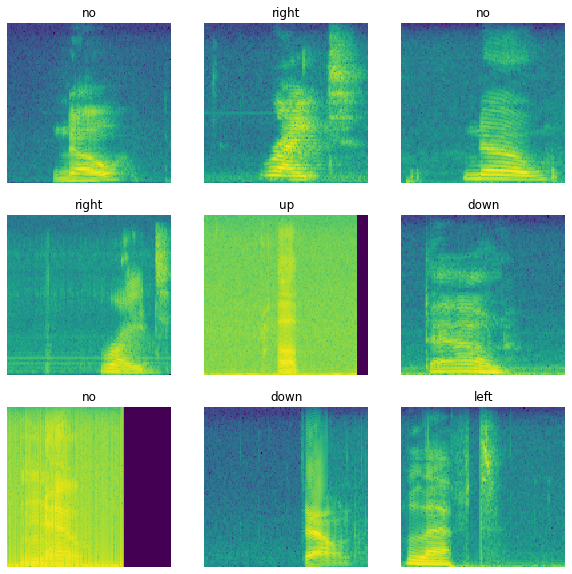

In [18]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_dataset.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [19]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
  return output_ds

In [20]:
train_ds = spectrogram_dataset
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [21]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [22]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [23]:
for spectrogram, _ in spectrogram_dataset.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(spectrogram_dataset.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [25]:
EPOCHS = 5
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/5
100/100 [==============================] - 19s 183ms/step - loss: 1.7582 - accuracy: 0.3819 - val_loss: 1.3105 - val_accuracy: 0.5713
Epoch 2/5
100/100 [==============================] - 12s 116ms/step - loss: 1.1790 - accuracy: 0.5795 - val_loss: 0.9172 - val_accuracy: 0.6975
Epoch 3/5
100/100 [==============================] - 12s 116ms/step - loss: 0.8929 - accuracy: 0.6859 - val_loss: 0.7515 - val_accuracy: 0.7563
Epoch 4/5
100/100 [==============================] - 12s 124ms/step - loss: 0.7378 - accuracy: 0.7341 - val_loss: 0.6629 - val_accuracy: 0.7775
Epoch 5/5
100/100 [==============================] - 12s 123ms/step - loss: 0.6181 - accuracy: 0.7822 - val_loss: 0.6105 - val_accuracy: 0.7962


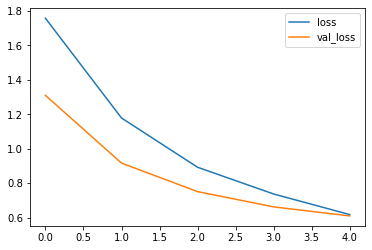

In [26]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [27]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [28]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 80%


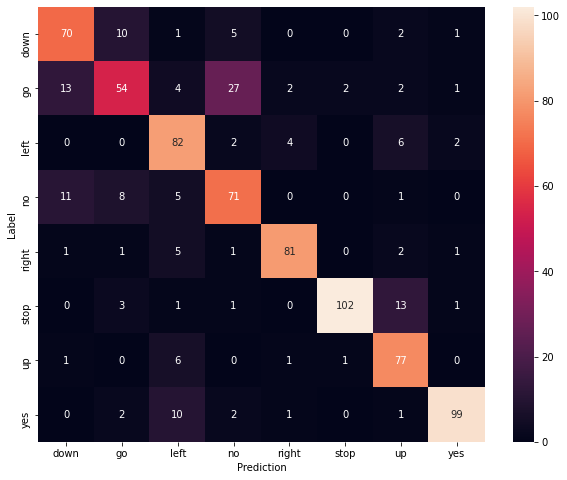

In [29]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [152]:
sample_file = 'output.wav'
sample_file1 = data_dir/'no/0ab3b47d_nohash_0.wav'
w = decode_audio(str(sample_file))
w1 = decode_audio(str(sample_file1))
print(w[0:5])
print(w1[0:5])
sample_ds = preprocess_dataset([str(sample_file)])

tf.Tensor(
[ 0.0000000e+00  0.0000000e+00 -3.0517578e-05  0.0000000e+00
  0.0000000e+00], shape=(5,), dtype=float32)
tf.Tensor(
[ 0.0000000e+00 -3.0517578e-05 -1.2207031e-04 -6.1035156e-05
  0.0000000e+00], shape=(5,), dtype=float32)
waveform:  (None,) <dtype: 'float32'> <class 'tensorflow.python.framework.ops.Tensor'>
waveform:  (None,) <dtype: 'float32'> <class 'tensorflow.python.framework.ops.Tensor'>


In [150]:
for spectrogram, label in sample_ds.batch(1):
    print(spectrogram, label)

InvalidArgumentError: slice index -1 of dimension 0 out of bounds.
	 [[{{node strided_slice}}]] [Op:IteratorGetNext]

In [57]:
for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  print(commands)
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

InvalidArgumentError: Dimension -4480 must be >= 0
	 [[{{node zeros}}]] [Op:IteratorGetNext]